# Active Learning

### Hyperparams

In [1]:
TRAIN_VAL_SPLIT = 0.1
BATCH_SIZE = 32

EPOCHS_BASELINE = 3

EPOCHS_AL = 1
AL_SAMPLE_PERC = 0.05

### Imports

In [2]:
# General
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time
import math

import tensorflow as tf

# CNNs
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

# TensorBoard
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

## Baseline CNN Method

### Full dataset

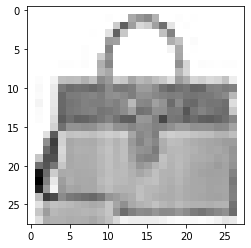

(60000, 28, 28)

In [3]:
(X_train_baseline, y_train_baseline), (X_test_baseline, y_test_baseline) = tf.keras.datasets.fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

X_train_baseline = tf.keras.utils.normalize(X_train_baseline, axis=1)
X_test_baseline = tf.keras.utils.normalize(X_test_baseline, axis=1)

plt.imshow(X_train_baseline[np.random.randint(0, X_train_baseline.shape[0])], cmap=plt.cm.binary)
plt.show()

X_train_baseline.shape

### CNN model

In [4]:
no_channels = 1
input_shape = (X_train_baseline.shape[1], X_train_baseline.shape[2], no_channels)

# sequential apif
# convolutional layers: specify no. conv filters (to give certain output shape), kernel dimensions
baseline_model = Sequential([
    Conv2D(64, (3, 3), input_shape=input_shape, activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(64, activation="relu"),

    Dense(10, activation="softmax")
])

# compile model
baseline_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# fit model
baseline_history = baseline_model.fit(X_train_baseline, y_train_baseline, epochs=EPOCHS_BASELINE, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)

Epoch 1/3
1688/1688 [==============================] - 9s 4ms/step - loss: 0.4986 - accuracy: 0.8151 - val_loss: 0.3548 - val_accuracy: 0.8675
Epoch 2/3
1688/1688 [==============================] - 6s 3ms/step - loss: 0.3331 - accuracy: 0.8763 - val_loss: 0.3047 - val_accuracy: 0.8870
Epoch 3/3
1688/1688 [==============================] - 6s 3ms/step - loss: 0.2901 - accuracy: 0.8931 - val_loss: 0.2910 - val_accuracy: 0.8895


313/313 [==============================] - 1s 3ms/step - loss: 0.3151 - accuracy: 0.8840
loss = 0.31507548689842224
accuracy = 0.8840000033378601


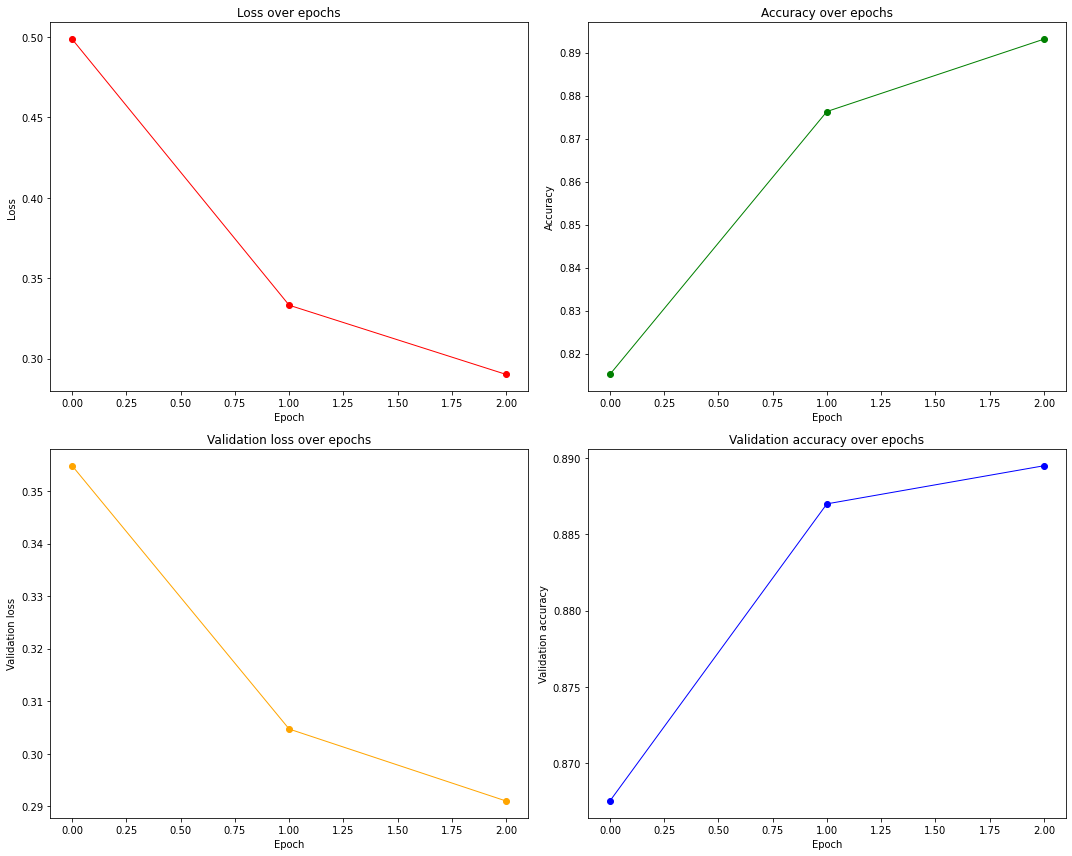

In [5]:
test_loss_baseline, test_acc_baseline = baseline_model.evaluate(X_test_baseline, y_test_baseline)
print(f"loss = {test_loss_baseline}")
print(f"accuracy = {test_acc_baseline}")

fig, ax = plt.subplots(2, 2, figsize=(15, 12))

baseline_loss = baseline_history.history['loss']
ax[0, 0].plot(baseline_loss, linewidth=1.0, color='red', marker='o')
ax[0, 0].set(title=f'Loss over epochs', xlabel='Epoch', ylabel='Loss')

baseline_accuracy = baseline_history.history['accuracy']
ax[0, 1].plot(baseline_accuracy, linewidth=1.0, color='green', marker='o')
ax[0, 1].set(title=f'Accuracy over epochs', xlabel='Epoch', ylabel='Accuracy')

baseline_valloss = baseline_history.history['val_loss']
ax[1, 0].plot(baseline_valloss, linewidth=1.0, color='orange', marker='o')
ax[1, 0].set(title=f'Validation loss over epochs', xlabel='Epoch', ylabel='Validation loss')

baseline_valacc = baseline_history.history['val_accuracy']
ax[1, 1].plot(baseline_valacc, linewidth=1.0, color='blue', marker='o')
ax[1, 1].set(title=f'Validation accuracy over epochs', xlabel='Epoch', ylabel='Validation accuracy')
    
plt.tight_layout()
plt.show()

## Active learning process

1. Gather full dataset.
2. Split full dataset into *training* and *testing* datasets.
3. Split training dataset into labelled *pool* (initially the *seed*) and unlabelled *validation* sets.
4. Initially train model over *seed*.
5. Use model to generate prediction probabilities over validation set.
6. Evaluate importance function over instances in the validation set.
7. Select the top $k$ most important instances, label, and move to the pool dataset.
8. Renormalise pool and retrain model.
9. Repeat for until max. epochs or accuracy goal is met.
10. Test final model on testing dataset.

### Dataset splitting

In [6]:
# 1. pull full dataset and 2. conduct train-test split
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# normalise datasets
X_train = tf.keras.utils.normalize(X_train, axis=1)
X_test = tf.keras.utils.normalize(X_test, axis=1)

# 3. split into seed pool and validation sets
k = math.floor(X_test.shape[0] * AL_SAMPLE_PERC)
print(f"k = {k}")

X_pool = X_train[:k]
y_pool = y_train[:k]
X_val = X_train[k:]
y_val = y_train[k:]

k = 500


### Model to be trained

In [7]:
no_channels = 1
input_shape = (X_train.shape[1], X_train.shape[2], no_channels)

al_model = Sequential([
    Conv2D(64, (3, 3), input_shape=input_shape, activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(64, activation="relu"),

    Dense(10, activation="softmax")
])

al_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# 4. initially train model over seed pool
print("Initial seed training")
print(f"Pool:\n   X: {X_pool.shape}, y: {y_pool.shape}")
print(f"Vali:\n   X: {X_val.shape}, y: {y_val.shape} \n")

history = al_model.fit(X_pool, y_pool, epochs=EPOCHS_AL, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)

Initial seed training
Pool:
   X: (500, 28, 28), y: (500,)
Vali:
   X: (59500, 28, 28), y: (59500,) 

15/15 [==============================] - 1s 23ms/step - loss: 2.1701 - accuracy: 0.3178 - val_loss: 1.9263 - val_accuracy: 0.3000


In [8]:
pool_sizes = []
pool_sizes.append(X_pool.shape[0])

losses = []
losses.extend(history.history['loss'])

accuracies = []
accuracies.extend(history.history['accuracy'])

losses_val = []
losses_val.extend(history.history['val_loss'])

accuracies_val = []
accuracies_val.extend(history.history['val_accuracy'])

### Training loop, computing importance scores and building pool

In [10]:
# importance function
def split_by_importance(probabilities, X_validation, y_validation, sample):
    # 6. calculate importance of each instance (version 1: uncertainty sampling)
    importance_scores = np.argmax(probabilities, axis=1)

    # 7. select k most important instances and move to pool
    important_indices = np.argpartition(importance_scores, sample)
    important_indices = important_indices[:sample]

    X = X_validation[important_indices]
    y = y_validation[important_indices]

    # update validation set
    val_indices = [i for i in range(0, X_validation.shape[0]) if i not in important_indices]
    X_validation = X_validation[val_indices]
    y_validation = y_validation[val_indices]

    return X, y, X_validation, y_validation

In [12]:
iterations = 20

for it in range(iterations):
    # 5. generate prediction probabiltiies of validation set
    val_probs = al_model.predict(X_val)

    # 6./7. calculate move k most important instances to pool
    X_important, y_important, X_val, y_val = split_by_importance(val_probs, X_val, y_val, k)

    X_pool = np.append(X_pool, X_important, axis=0)
    y_pool = np.append(y_pool, y_important, axis=0)

    # 8. renormalise and retrain model over new pool
    X_pool = tf.keras.utils.normalize(X_pool, axis=1)
    X_val = tf.keras.utils.normalize(X_val, axis=1)

    print(f"\nIteration {it}")
    history = al_model.fit(X_pool, y_pool, epochs=EPOCHS_AL, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)

    # print(f"Pool:\n   X: {X_pool.shape}, y: {y_pool.shape}")
    # print(f"Vali:\n   X: {X_val.shape}, y: {y_val.shape}")

    # save metrics from this iteration
    pool_sizes.append(X_pool.shape[0])
    losses.extend(history.history['loss'])
    accuracies.extend(history.history['accuracy'])
    losses_val.extend(history.history['val_loss'])
    accuracies_val.extend(history.history['val_accuracy'])


Iteration 0
29/29 [==============================] - 0s 8ms/step - loss: 1.2567 - accuracy: 0.5589 - val_loss: 0.6350 - val_accuracy: 0.7600

Iteration 1
43/43 [==============================] - 0s 8ms/step - loss: 0.7497 - accuracy: 0.7178 - val_loss: 0.6009 - val_accuracy: 0.7200

Iteration 2
57/57 [==============================] - 0s 6ms/step - loss: 0.6035 - accuracy: 0.7583 - val_loss: 0.4454 - val_accuracy: 0.8200

Iteration 3
71/71 [==============================] - 0s 6ms/step - loss: 0.5302 - accuracy: 0.7876 - val_loss: 0.4446 - val_accuracy: 0.8240

Iteration 4
85/85 [==============================] - 0s 5ms/step - loss: 0.4975 - accuracy: 0.8030 - val_loss: 0.4919 - val_accuracy: 0.8167

Iteration 5
99/99 [==============================] - 1s 5ms/step - loss: 0.4653 - accuracy: 0.8114 - val_loss: 0.5309 - val_accuracy: 0.7457

Iteration 6
113/113 [==============================] - 0s 4ms/step - loss: 0.4505 - accuracy: 0.8150 - val_loss: 0.3945 - val_accuracy: 0.8350

Ite

In [13]:
test_loss_al, test_acc_al = al_model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print(f"loss = {test_loss_al}")
print(f"accuracy = {test_acc_al}")

313/313 [==============================] - 1s 2ms/step - loss: 0.6134 - accuracy: 0.8077
loss = 0.6133635640144348
accuracy = 0.807699978351593


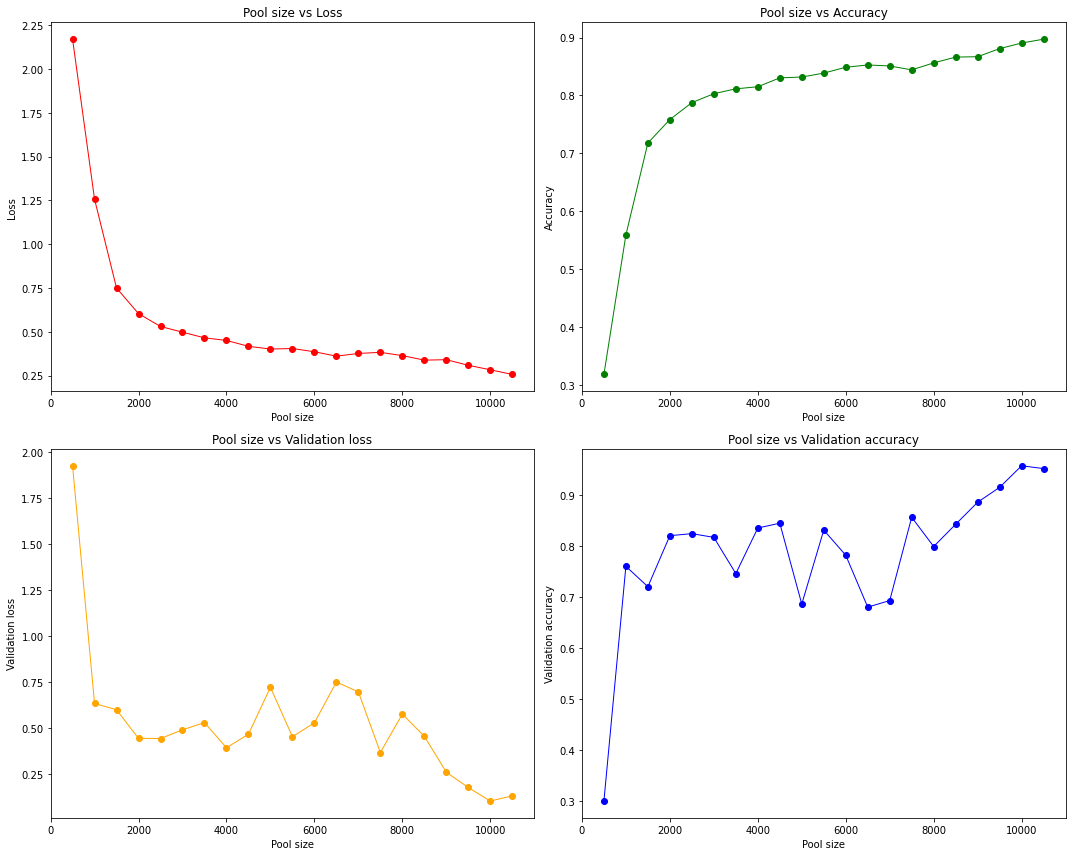

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(15, 12))

ax[0, 0].plot(pool_sizes, losses, linewidth=1.0, color='red', marker='o')
ax[0, 0].set(title=f'Pool size vs Loss', xlabel='Pool size', ylabel='Loss')

ax[0, 1].plot(pool_sizes, accuracies, linewidth=1.0, color='green', marker='o')
ax[0, 1].set(title=f'Pool size vs Accuracy', xlabel='Pool size', ylabel='Accuracy')

ax[1, 0].plot(pool_sizes, losses_val, linewidth=1.0, color='orange', marker='o')
ax[1, 0].set(title=f'Pool size vs Validation loss', xlabel='Pool size', ylabel='Validation loss')

ax[1, 1].plot(pool_sizes, accuracies_val, linewidth=1.0, color='blue', marker='o')
ax[1, 1].set(title=f'Pool size vs Validation accuracy', xlabel='Pool size', ylabel='Validation accuracy')

plt.tight_layout()
plt.show()